#Lyrics Generation using  Character level RNN


In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [0]:
!pip install -q tqdm
from tqdm import tqdm

In [0]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.transforms as transforms
from IPython import display
import time


In [0]:
use_cuda = False

# Dataset


In [0]:
import requests
import string
import random

all_characters = string.printable
n_characters = len(all_characters)

def DownloadFile(url):
    local_filename = url.split('/')[-1]
    r = requests.get(url)
    return r.text

def char_tensor(string):
   
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            
            continue
    return tensor  

def random_training_set(chunk_len, batch_size, file):
     '''
     TODO: Convert to stateful LSTM with more features
     '''
     inp = torch.LongTensor(batch_size, chunk_len)
     target = torch.LongTensor(batch_size, chunk_len)
     file_len = len(file)

     for bi in range(batch_size):

          start_index = random.randint(0, file_len - chunk_len)
          end_index = start_index + chunk_len + 1
          chunk = file[start_index:end_index]
          
               
          inp[bi] = char_tensor(chunk[:-1])
          target[bi] = char_tensor(chunk[1:])

     inp = Variable(inp)
     target = Variable(target)

     if use_cuda:
          inp = inp.cuda()
          target = target.cuda()

     return inp, target
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# target_url = "https://raw.githubusercontent.com/ryanmcdermott/trump-speeches/master/speeches.txt"
target_url = "https://raw.githubusercontent.com/Blaziking/Lyrics-generation-using-Ngrams/master/Dylan%2C%20Bob%20Lyrics%2C%201962-2001%20-%20preprocessed.txt"

data = DownloadFile(target_url)
#print(random_training_set(10, 8, data))
print(data[90:100])

ht I’d see


In [0]:
print(data[:186])

﻿
Talking New York


Ramblin’ outa the wild West

Leavin’ the towns I love the best

Thought I’d seen some ups and downs

’Til I come into New York town

People goin’ down to the ground



In [0]:
len(data)

903947

#Model
In this code we use Pytorch already implemented Recurrent Neural Network Cell computation with `nn.RNN` and `nn.LSTM`

#Train

In [0]:
# https://github.com/spro/char-rnn.pytorch
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="rnn", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(0.1)

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        if model=="lstm":
          self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
          
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.dropout(output)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

###Iinitialize the model

In [0]:
hidden_size = 100
learning_rate = 0.005
cell = "rnn"
n_layers = 2

decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=cell,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

if use_cuda:
    decoder.cuda()
    


In [0]:
n_epochs = 2000
chunk_len = 200
print_every = 100
plot_every = 10
batch_size = 50

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if use_cuda:
      if isinstance(hidden, tuple):
            hidden = (hidden[0].cuda(), hidden[1].cuda())
      else:
            hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

# Generate Text

In [0]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))
    
    if cuda:
      if isinstance(hidden, tuple):
            hidden = (hidden[0].cuda(), hidden[1].cuda())
      else:
            hidden = hidden.cuda()
    
    if cuda:
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

In [0]:
start = time.time()
all_losses = []
loss_avg = 0

print("Training for %d epochs..." % n_epochs)
for epoch in tqdm(range(1, n_epochs + 1)):
    loss = train(*random_training_set(chunk_len, batch_size, data))
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print('loss: ', loss)
        print(generate(decoder, 'H', 100, cuda=use_cuda), '\n')
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / print_every)
        loss_avg = 0

  0%|          | 0/2000 [00:00<?, ?it/s]

Training for 2000 epochs...


  5%|▌         | 100/2000 [00:45<15:09,  2.09it/s]

 45s (100 5%) 1.8379]
loss:  1.8378939819335938
He wald a beatrow that stat to dead

A a ending jut hor that we

Noed ir to you0ll a call

I peade ma 



 10%|█         | 200/2000 [01:31<14:00,  2.14it/s]

 31s (200 10%) 1.7895]
loss:  1.7894905090332032
He satter can0t were to the can trough my alase

The bonsty of gannin0 he0s wonders, 0Ning

Treved co 



 15%|█▌        | 300/2000 [02:17<13:17,  2.13it/s]

 17s (300 15%) 1.6451]
loss:  1.6450860595703125
Him

When you, roll I shothin0 fawn you0ll gabery doof

How

Things back bind

The stace

0hout ten s 



 20%|██        | 400/2000 [03:03<12:25,  2.15it/s]

 3s (400 20%) 1.6013]
loss:  1.6013270568847657
He prome wom end bcound me thinks a little will be the wantle that thinking down her unreet bust have 



 25%|██▌       | 500/2000 [03:49<11:43,  2.13it/s]

 49s (500 25%) 1.5832]
loss:  1.5831800842285155
Her was bad and the sun was tomes on just dones be see down of the done

When I do I the wettern toni 



 30%|███       | 600/2000 [04:35<11:00,  2.12it/s]

 35s (600 30%) 1.5389]
loss:  1.5389125061035156
Her your done was bed my nead in friends hall is

I go

That somethin0 for you

Well, the Can say Jac 



 35%|███▌      | 700/2000 [05:21<10:43,  2.02it/s]

 21s (700 35%) 1.5331]
loss:  1.5331491088867188
He carced away

True my feeled my diasons will now, the night

I0m jolites

To tree

You all the did  



 40%|████      | 800/2000 [06:07<09:48,  2.04it/s]

 7s (800 40%) 1.5203]
loss:  1.5203265380859374
Had Ened

Could overthip comes this hure?

Well, I0m ready

Fats

This way you0re hid ma He0s drown f 



 45%|████▌     | 900/2000 [06:53<08:32,  2.15it/s]

 53s (900 45%) 1.4935]
loss:  1.4935354614257812
Hey been the beron

Well, Gy!


I been a-tellly I0m got no pise

But that0s like he sit I0m over is d 



 50%|█████     | 1000/2000 [07:39<07:51,  2.12it/s]

 39s (1000 50%) 1.5117]
loss:  1.5117115783691406
Hen that closerin0 you all at million in my let I got a breath you walkin0 to so for out of the sun i 



 55%|█████▌    | 1100/2000 [08:25<06:56,  2.16it/s]

 25s (1100 55%) 1.4998]
loss:  1.4997879028320313
Hen baid of back up at you that no Blue Crow

Baby

Welre don0t just lookin0 abody beth concas her ti 



 60%|██████    | 1200/2000 [09:10<06:14,  2.13it/s]

 10s (1200 60%) 1.4843]
loss:  1.4843319702148436
He was on a do

You mother by their good the morner or like his body so lose me

The judge far in an  



 65%|██████▌   | 1300/2000 [09:56<05:28,  2.13it/s]

 56s (1300 65%) 1.5078]
loss:  1.5078059387207032
Her mothing

And then by a think is no distance the passed on badsy, I, I got her chead

Oh, once

An 



 70%|███████   | 1400/2000 [10:42<04:50,  2.06it/s]

 42s (1400 70%) 1.5167]
loss:  1.5166665649414062
Hispered of love

In a-time about talkin0 sumpeaning

To hears stoling ponnagg

I can0t or stite chop 



 75%|███████▌  | 1500/2000 [11:28<03:56,  2.11it/s]

 28s (1500 75%) 1.4628]
loss:  1.4628276062011718
He was rolling like upleth Down

Trouble my an0 hold

They been because you0ll make you

God I was pl 



 80%|████████  | 1600/2000 [12:14<03:08,  2.12it/s]

 14s (1600 80%) 1.4782]
loss:  1.4781565856933594
Hang that you shoughteard the forging the rage the one of the beator the rarad

Took him on old mind, 



 85%|████████▌ | 1700/2000 [13:00<02:19,  2.15it/s]

 0s (1700 85%) 1.4619]
loss:  1.4618914794921876
Heress age sitce to the jiscaning every a-gorn

I love it back about

I can0t get right

Ain0t you go 



 90%|█████████ | 1800/2000 [13:46<01:32,  2.16it/s]

 46s (1800 90%) 1.4238]
loss:  1.4237648010253907
He thing

If you got up to me

With you to his child the sunderty soned old polenty peoplense for the 



 95%|█████████▌| 1900/2000 [14:32<00:47,  2.09it/s]

 32s (1900 95%) 1.4684]
loss:  1.468448486328125
Hard to your head of their hand

You know I see the land

To sea out for your thinking the judge, the 



100%|██████████| 2000/2000 [15:17<00:00,  2.15it/s]

 17s (2000 100%) 1.4557]
loss:  1.455680389404297
Head

You, your way at eyes that must back for?

With a lot!

Well, I0ll be here me a spard

You can  



###Plotting the losses

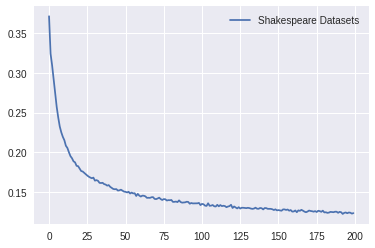

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses, label="""dylan Dataset""")
plt.legend()

## Let's try sampling with different temperature:

In [0]:
print(generate(decoder, prime_str="I ", temperature= 100, cuda=use_cuda)) # temperature = 100

:KK~gcOMZXM|*Re%E@7)wgUy!3(AD

vl\rG_B`hgN


In [0]:
print(generate(decoder, prime_str="I ", temperature=0.8 , cuda=use_cuda)) # temperature = .8

I state.
But is a very soction is one of their. Our -- they don0t know what thall have allecantracy a


In [0]:
print(generate(decoder, prime_str="I ", temperature=.4 , cuda=use_cuda)) # temperature = .4 

I have to the poor gone to stay you got my life breather

I0m gonna give the where the man to the wind


In [0]:
print(generate(decoder, prime_str="He", temperature=.34 , cuda=use_cuda, predict_len = 500)) # temperature = .3 

He prother tell you the shore

She said the morning

To be what I got to see the wind of separy life when you can0t see me to see you a got the bark in the mind in bed who knows the way if I was the change of the back

I can0t see the chain

When you gonna had to get and the missise

Well, the country

When the dead with a door

I said, 0You can0t she said, 0I0ll know the skin for the stare

Can0t stand alone

The could have to do word

Well, the should you can0t see me

But I0m what I0m so the tr


In [0]:
print(generate(decoder, prime_str="I ", temperature=.1 , cuda=use_cuda)) # temperature = .1 

I am a starts,, they don0t want the press and they0re going to be a lot of the people,, they0re going 


In [0]:
print(generate(decoder, prime_str="I ", temperature=0 , cuda=use_cuda)) # temperature = 0 

I abaa000ab00ab00000000000ab00000000000000000000000000000000000000000000000000000000000000000000000000


### Example
Inserting  a meaningful sentence 

In [0]:
print(generate(decoder, prime_str="Repulican will", predict_len = 1000, temperature = .34, cuda=use_cuda))

Repulican will be all these politics but I would have been the way they could do that stuff and they don0t get the problem in New Hampshire. It0s a country that have been a lot of the press again. We0re going to be the walls on the people don0t want to be a single country but they don0t want to be about the press and they want to be the people are going to happen to do it and they have a lot of people that want to be things that are believe it. They want to be a lot of the thing. I was a great all of the great country and they can0t folks. I want to do to be about the people because they don0t want to say that I was a great country in that was a big a lot of the country. They don0t think the Uridasy. You know what they get the country. They have a tax in the way that is done it and we have to say a better than they0re going to be the people are don0t want to come in the people are like the people that they want to be terrible but they don0t want to the people and they can0t get the pro

In [0]:
print(generate(decoder, prime_str="Infact ", temperature = .34, cuda=use_cuda))

Infact us and they don0t know what they don0t know what anywhere that are about the best out of the other a


In [0]:
print(generate(decoder, prime_str="I watch the speeches of these people", temperature = .34, cuda=use_cuda))

I watch the speeches of these people are beautiful and they do that by the way we0re going to have a disasters and don0t have to be a te


In [0]:
print(generate(decoder, prime_str="We have to repeal Obamacare", temperature = .3, cuda=use_cuda))

We have to repeal Obamacare. We have to say the statements are the one of the particals. I was a great come in the country in t


In [0]:
print(generate(decoder, prime_str="Make America ", temperature = .8, cuda=use_cuda))

Make America bilding the Wallies that they0ve keep noter and they take into the country buildickly a take care of


In [0]:
print(generate(decoder, prime_str="We, need a leader ", temperature = .8, cuda=use_cuda))

We, need a leader for Obama car everything the bigger and 130,000 and agree ISIS. You know, they0re doing. And that, t


#Experiment with Input

##We need 
* noun after need

In [0]:
print(generate(decoder, prime_str="We, need ", temperature = .8, cuda=use_cuda))

We, need them and it0s a good leave the Clinton. And I0m going to or the really spect to do in trouble making


In [0]:
print(generate(decoder, prime_str="We, need ", temperature = .8, cuda=use_cuda))

We, need to see the Moducting to do a change and we have a moneminator were to actually to be knows are didib


In [0]:
print(generate(decoder, prime_str="We, need ", temperature = .8, cuda=use_cuda))

We, need our job, and they don0t by the veterpaid from a successful and we se its of our happening and they h


In [0]:
print(generate(decoder, prime_str="We, need ", temperature = .8, cuda=use_cuda))

We, need the running and just as the time if we0re going to your remember the send some friend, benation that


##We need + more spaces

In [0]:
print(generate(decoder, prime_str="We, need  ", temperature = .8, cuda=use_cuda))

We, need  Merboy and then get it.
And you know, I gave the monitier." We0re going to be do trage China. They 


In [0]:
print(generate(decoder, prime_str="We, need  ", temperature = .8, cuda=use_cuda))

We, need  in New Press you know what we0re going to find of the usest that he on great people.
But go to do w


In [0]:
print(generate(decoder, prime_str="We, need  ", temperature = .8, cuda=use_cuda))

We, need  Americans. They bad vow you. And then a lot attines that0s go are foreign but aroond. So you send in


In [0]:
print(generate(decoder, prime_str="We, need                    ", temperature = .8, cuda=use_cuda))

We, need                    We don0t could press in they0re while to 0 I0ll be the vets. We have a very, what they don0t have to


In [0]:
print(generate(decoder, prime_str="We, need                     ", temperature = .8, cuda=use_cuda))

We, need                     geneled this the campaign and support but there was was and I was comes. And they0re don0t do it, th


#We, need a leader

In [0]:
print(generate(decoder, prime_str="We, need a leader ", temperature = .8, cuda=use_cuda))

We, need a leader out of the president.
Now, even the presidence out of their politically, we have tremendous ads sai


In [0]:
print(generate(decoder, prime_str="We, need a leader ", temperature = .8, cuda=use_cuda))

We, need a leader of what is not seen saying everybody is a lot of a people better in.Shishany it world and we0re goin


In [0]:
print(generate(decoder, prime_str="We, need a leader ", temperature = .8, cuda=use_cuda))

We, need a leader wither of packed on Wountas itterdia. They0re tell into your bay is smope.


I whit iago and raw 


In [0]:
print(generate(decoder, prime_str="We, need a leader ", temperature = .8, cuda=use_cuda))

We, need a leader forget to says I do.  They are now with our first. I think that the credit that cameran agreated at 


In [0]:
print(generate(decoder, prime_str="We, need a leader ", temperature = .8, cuda=use_cuda))

We, need a leader of for something to start countries. Very supposed to be a year. But we have all anything here. He0s
